## Possibly Splitting the data train test on the months 

chat: suggested that we train one month for training and one for testing bc random could intoduce a bias when we want to keep the temporal data to keep the trends

Why? Because our data has a natural time order random train-test splitting can introduce data leakage bc the model sees future patterns during training that it shouldnt have access to (feb trends while training on Jan)  --> this then leads to inflating performance metrics making the modle look better than it actually is

In [31]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime

In [32]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks
Loaded file: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/final_cleaned_jan_feb_2023_taxi_data.csv
Initial shape: (5646828, 19)
Dataset loaded successfully! Shape: (5646828, 19)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'is_weekend']


## Preprossing: Creating datetime features and target

We created a target before dropping componets becasue our goal is to predict fare per minute: fare_amount (total fare) and trip_duration_min (trip in time in minutes) we need to calc the target before dropping the columns that create it. 


These features that we dropped were used to calculate the target (fare_per_minute). If the model sees those during training, it's like giving it the answer ahead of time — the model "cheats" and learns unrealistic relationships. Some features like trip_speed (derieved from trip_distance / duration strongle correlates with the denomiator), trip_speed_mph (same as previous one just in different units), and trip_distance(correlated with fare_amount and possibly used in fare calc by the taxi system) werent directly involved in the fare_per_minute formula but they are derived from or high correlated with its components due to that I decided to drop these features to prevent leakage

In [33]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Create target BEFORE dropping fare_amount and trip_duration_min
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']

# Drop leakage features
leakage_features = [
    'fare_amount', 'trip_duration_min', 'trip_speed',
    'trip_speed_mph', 'trip_distance'
]
df.drop(columns=leakage_features, inplace=True)

## Split by time Jan = Train, Feb = Test

A random split would mix the months together and hide seasonal patterns or temporal shifts. This time-based split mimics real-world deployment.Will have to be careful when moving forward and adding more months. 

In [ ]:

# Ensure your date ranges are accurate
jan_mask = df['pickup_date'].dt.month == 1
feb_mask = df['pickup_date'].dt.month == 2

train_df = df[jan_mask].copy()
test_df = df[feb_mask].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (2899058, 14)
Test shape: (2747770, 14)


In [35]:
# Define target and features
target_column = 'fare_per_minute'

# Ensure target column exists
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

# Add target back for encoding 
X_train_full = X_train.copy()
X_train_full['fare_per_minute'] = y_train

X_test_full = X_test.copy()
X_test_full['fare_per_minute'] = y_test

# Base encoding 
def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    onehot_cols = ['pickup_borough', 'dropoff_borough', 'pickup_service_zone', 'dropoff_service_zone']
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)
    time_order = {
        'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    return df_encoded

#  Target Encoding 
def target_encode_train_and_apply(train_df, test_df, target_column, zone_columns):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_columns:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded


#  Base encode the full data with target temporarily added
train_base = base_encode(X_train_full)
test_base = base_encode(X_test_full)

#  Target encode the zone columns
train_encoded, test_encoded = target_encode_train_and_apply(
    train_base, test_base,
    target_column='fare_per_minute',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

#  Drop datetime columns
for col in ['pickup_date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']:
    train_encoded.drop(columns=col, errors='ignore', inplace=True)
    test_encoded.drop(columns=col, errors='ignore', inplace=True)

#  NOW drop the target from the features
X_train_final = train_encoded.drop(columns=['fare_per_minute'])
X_test_final = test_encoded.drop(columns=['fare_per_minute'])

# Final check
print("Final training columns:", X_train_final.columns)

Final training columns: Index(['pickup_hour', 'pickup_day_of_week', 'is_weekend',
       'pickup_borough_Brooklyn', 'pickup_borough_EWR',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'pickup_borough_Staten Island', 'pickup_borough_Unknown',
       'dropoff_borough_Brooklyn', 'dropoff_borough_EWR',
       'dropoff_borough_Manhattan', 'dropoff_borough_Queens',
       'dropoff_borough_Staten Island', 'dropoff_borough_Unknown',
       'pickup_service_zone_Boro Zone', 'pickup_service_zone_EWR',
       'pickup_service_zone_Yellow Zone', 'dropoff_service_zone_Boro Zone',
       'dropoff_service_zone_EWR', 'dropoff_service_zone_Yellow Zone',
       'time_of_day_encoded', 'pickup_zone_target_encoded',
       'dropoff_zone_target_encoded'],
      dtype='object')


## Train and Eval LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 2899058, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.275115
Training until validation scores don't improve for 10 rounds
[10]	training's l1: 0.228707	valid_1's l1: 0.224784
[20]	training's l1: 0.212711	valid_1's l1: 0.209498
[30]	training's l1: 0.204716	valid_1's l1: 0.202043
[40]	training's l1: 0.200044	valid_1's l1: 0.197619
[50]	training's l1: 0.197058	valid_1's l1: 0.194784
[60]	training's l1: 0.195134	valid_1's l1: 0.193006
[70]	training's l1: 0.193596	valid_1's l1: 0.191529
[80]	tra

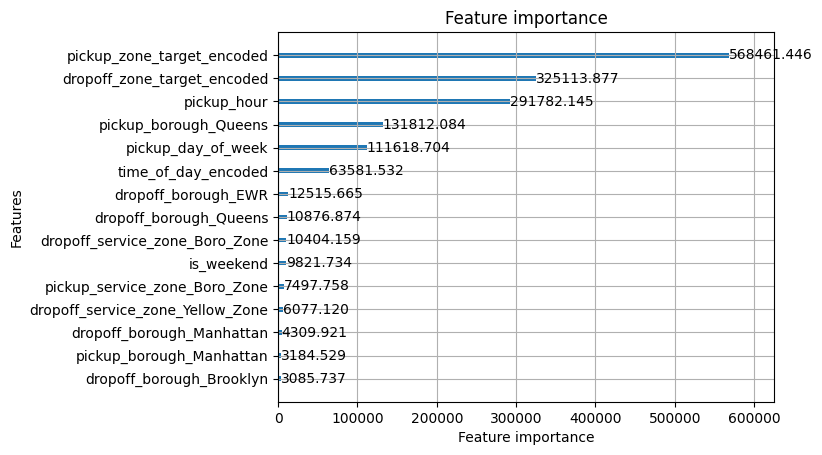

In [36]:
X_train_final = train_encoded.drop(columns='fare_per_minute')
y_train_final = train_encoded['fare_per_minute']
X_test_final = test_encoded.drop(columns='fare_per_minute')
y_test_final = test_encoded['fare_per_minute']

train_data = lgb.Dataset(X_train_final, label=y_train_final)
test_data = lgb.Dataset(X_test_final, label=y_test_final, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[early_stopping(10), log_evaluation(10)]
)

y_pred = model.predict(X_test_final)
print("MAE:", mean_absolute_error(y_test_final, y_pred))
print("R²:", r2_score(y_test_final, y_pred))
lgb.plot_importance(model, max_num_features=15, importance_type='gain');

## Train and Eval Linear Regession

Once again for a simple baseline comparison to show how well a basic model does against a more complex model such as LightGBM or Random Forest. This could also help indicate if there is still any data leakage if it preforms unsually well, and an extra sanity check for the models (if lighgbm is only a little better than linear could mean the dataset doesnt need complex models or that more feature engin is needed)

In [38]:
# Drop NaN values from encoded data
train_encoded_clean = train_encoded.dropna()
test_encoded_clean = test_encoded.dropna()

# Align y_train and y_test accordingly
y_train_clean = y_train.loc[train_encoded_clean.index]
y_test_clean = y_test.loc[test_encoded_clean.index]

# Fit model on cleaned data
lr_model = LinearRegression()
lr_model.fit(train_encoded_clean.drop(columns=['fare_per_minute']), y_train_clean)

# Predict
y_pred_lr = lr_model.predict(test_encoded_clean.drop(columns=['fare_per_minute']))

# Evaluate
mae_lr = mean_absolute_error(y_test_clean, y_pred_lr)
r2_lr = r2_score(y_test_clean, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression R²:  {r2_lr:.3f}")


Linear Regression MAE: 0.213
Linear Regression R²:  0.264
